# Normative Modelling: Bayesian Linear Regression

Welcome to this tutorial notebook that will go through the fitting and evaluation of Normative models with Bayesian Linear Regression.

Let's jump right in.

### Imports

In [1]:
import warnings
import logging


import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit import (
    BLR,
    BsplineBasisFunction,
    NormativeModel,
    NormData,
    load_fcon1000,
    plot_centiles,
    plot_qq,
    plot_ridge,
)

import pcntoolkit.util.output
import seaborn as sns

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(True)

## Load data

First we download a small example dataset from github.

In [2]:
# Download an example dataset
norm_data: NormData = load_fcon1000()

# Select only a few features
features_to_model = [
    "WM-hypointensities",
    "Right-Lateral-Ventricle",
    "Right-Amygdala",
    "CortexVol",
]
norm_data = norm_data.sel({"response_vars": features_to_model})

# Split into train and test sets
train, test = norm_data.train_test_split()


Process: 28764 - 2025-06-30 13:54:37 - Dataset "fcon1000" created.
    - 1078 observations
    - 1078 unique subjects
    - 1 covariates
    - 217 response variables
    - 2 batch effects:
    	sex (2)
	site (23)
    


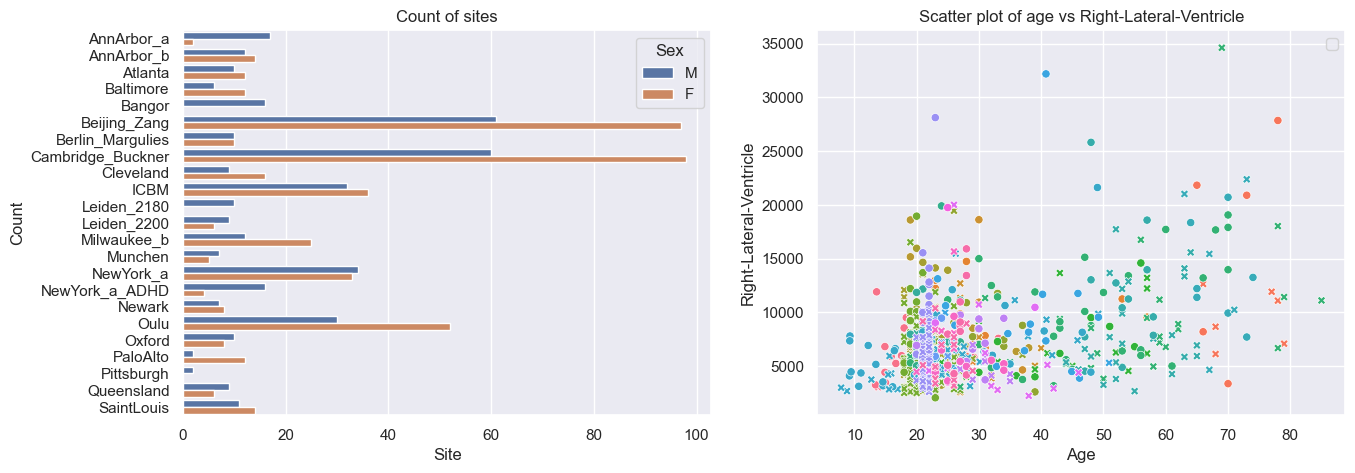

In [3]:
# Visualize the data
feature_to_plot = features_to_model[1]
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")


sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

## Creating a Normative model

A normative model has a regression model for each response variable. We provide a template regression model which is copied for each response variable. 

A template regression model can be anything that extends the `RegressionModel`. We provide a number of built-in regression models, but you can also create your own. 

Here we use the `BLR` class, which implements a Bayesian Linear Regression model. 

The `BLR` class has a number of parameters that can be set, determining whether and how batch effects are modeled, which basis expansion to use, and more. 

In [4]:
template_blr = BLR(
    name="template",
    basis_function_mean=BsplineBasisFunction(
        degree=3, nknots=5
    ),  # We use a B-spline basis expansion for the mean, so the predicted mean is a smooth function of the covariates
    fixed_effect=True,  # By setting fixed_effect=True, we \model offsets in the mean for each individual batch effect,
    heteroskedastic=True,  # We want the variance to be a function of the covariates too
    warp_name="warpsinharcsinh",  # We configure a sinh-arcsinh warp, so we can model flexible non-gaussian distributions
)

After specifying the regression model, we can configure a normative model. 

A normative model has a number of configuration options:
- `savemodel`: Whether to save the model after fitting.
- `evaluate_model`: Whether to evaluate the model after fitting.
- `saveresults`: Whether to save the results after evaluation.
- `saveplots`: Whether to save the plots after fitting.
- `save_dir`: The directory to save the model, results, and plots.
- `inscaler`: The scaler to use for the input data.
- `outscaler`: The scaler to use for the output data.




In [5]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=template_blr,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=False,
    # The directory to save the model, results, and plots.
    save_dir="resources/blr/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="standardize",
)

## Fit the model


With all that configured, we can fit the model. 

The `fit_predict` function will fit the model, evaluate it, and save the results and plots (if so configured). 

After that, it will compute Z-scores and centiles for the test set. 

All results can be found in the save directory. 

In [6]:
model.fit_predict(train, test)

Process: 28764 - 2025-06-30 13:54:37 - Fitting models on 4 response variables.
Process: 28764 - 2025-06-30 13:54:37 - Fitting model for WM-hypointensities.
Process: 28764 - 2025-06-30 13:54:40 - Fitting model for Right-Lateral-Ventricle.
Process: 28764 - 2025-06-30 13:54:42 - Fitting model for Right-Amygdala.
Process: 28764 - 2025-06-30 13:54:44 - Fitting model for CortexVol.
Process: 28764 - 2025-06-30 13:54:45 - Making predictions on 4 response variables.
Process: 28764 - 2025-06-30 13:54:45 - Computing z-scores for 4 response variables.
Process: 28764 - 2025-06-30 13:54:45 - Computing z-scores for CortexVol.
Process: 28764 - 2025-06-30 13:54:45 - Computing z-scores for Right-Amygdala.
Process: 28764 - 2025-06-30 13:54:45 - Computing z-scores for Right-Lateral-Ventricle.
Process: 28764 - 2025-06-30 13:54:45 - Computing z-scores for WM-hypointensities.
Process: 28764 - 2025-06-30 13:54:45 - Computing centiles for 4 response variables.
Process: 28764 - 2025-06-30 13:54:45 - Computing c

<xarray.NormData> Size: 98kB
Dimensions:            (observations: 216, response_vars: 4, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 11)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U23 368B 'WM-hypointensities' ... 'Co...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 2kB 'Munchen_sub96752' ... 'Quee...
    Y                  (observations, response_vars) float64 7kB 2.721e+03 .....
    X                  (observations, covariates) float64 2kB 63.0 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 7kB 0.7016 ... -...
    centiles           (centile, observations, response_vars) float64 35kB 60...
    logp               (observations, response_vars) float64 7kB -1.104 ... -...
    Yhat               (observations, response_vars) float64 7kB 1.371e+03 .....
    statistics         (response_vars, statistic) float64 352B -0.662 ... 0.9941
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {'sex': ['F', 'M'], 'site': ['AnnArbor_a'...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {'age': {'min': 7.88, 'max': 85.0}}
    batch_effect_covariate_ranges:  {'sex': {'F': {'age': {'min': 7.88, 'max'...

## Plot the results

The PCNtoolkit offers are a number of different plotting functions:
1. plot_centiles: Plot the predicted centiles for a model
2. plot_qq: Plot the QQ-plot of the predicted Z-scores
3. plot_ridge: Plot density plots of the predicted Z-scores

Let's start with the centiles.

Process: 28764 - 2025-06-30 13:54:47 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 4 response variables
    - 2 batch effects:
    	site (1)
	sex (1)
    
Process: 28764 - 2025-06-30 13:54:47 - Computing centiles for 4 response variables.
Process: 28764 - 2025-06-30 13:54:47 - Computing centiles for CortexVol.
Process: 28764 - 2025-06-30 13:54:47 - Computing centiles for Right-Amygdala.
Process: 28764 - 2025-06-30 13:54:47 - Computing centiles for Right-Lateral-Ventricle.
Process: 28764 - 2025-06-30 13:54:47 - Computing centiles for WM-hypointensities.
Process: 28764 - 2025-06-30 13:54:47 - Computing yhat for 4 response variables.
Process: 28764 - 2025-06-30 13:54:48 - Computing yhat for CortexVol.
Process: 28764 - 2025-06-30 13:54:48 - Computing yhat for Right-Amygdala.
Process: 28764 - 2025-06-30 13:54:48 - Computing yhat for Right-Lateral-Ventricle.
Process: 28764 - 2025-06-30 13:54:48 - Computing yhat for WM-hypointensities.


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 28764 - 2025-06-30 13:54:47 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


Process: 28764 - 2025-06-30 13:54:48 - Harmonizing data on 4 response variables.
Process: 28764 - 2025-06-30 13:54:48 - Harmonizing data for CortexVol.
Process: 28764 - 2025-06-30 13:54:48 - Harmonizing data for Right-Amygdala.
Process: 28764 - 2025-06-30 13:54:48 - Harmonizing data for Right-Lateral-Ventricle.
Process: 28764 - 2025-06-30 13:54:48 - Harmonizing data for WM-hypointensities.


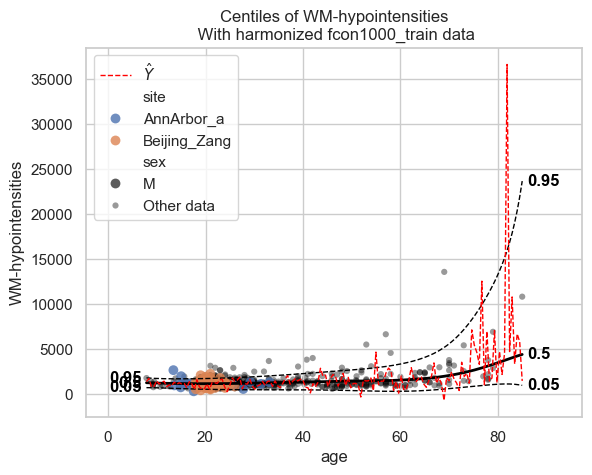

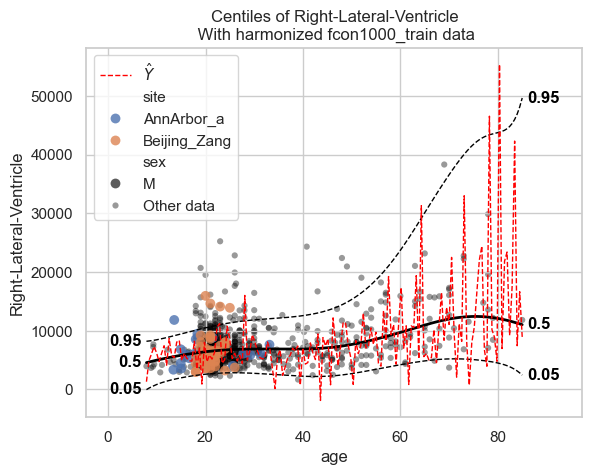

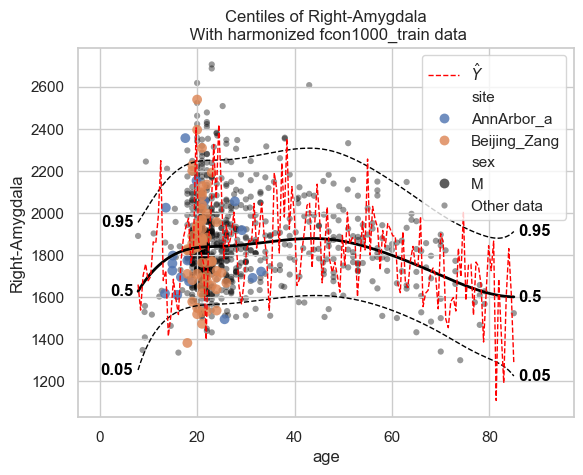

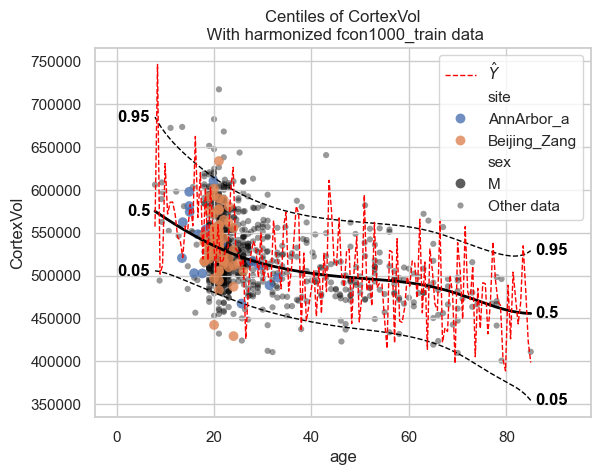

In [7]:
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=train,  # Scatter this data along with the centiles
    batch_effects={"site": ["Beijing_Zang", "AnnArbor_a"], "sex": ["M"]},  # Highlight these groups
    show_other_data=True,  # scatter data not in those groups as smaller black circles
    harmonize=True,  # harmonize the scatterdata, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
    show_yhat=True,
)

Now let's see the qq plots

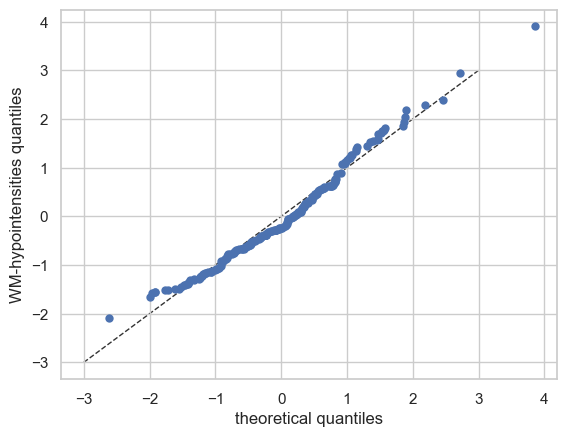

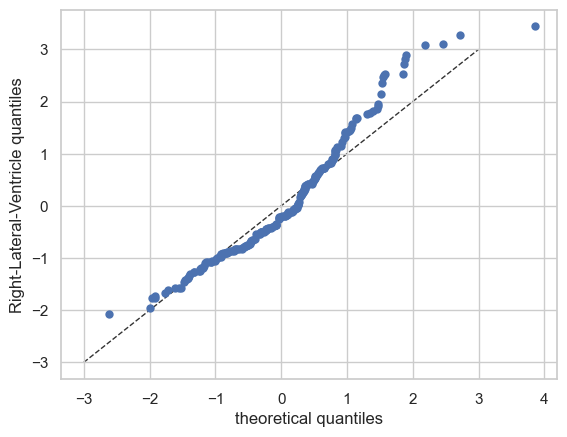

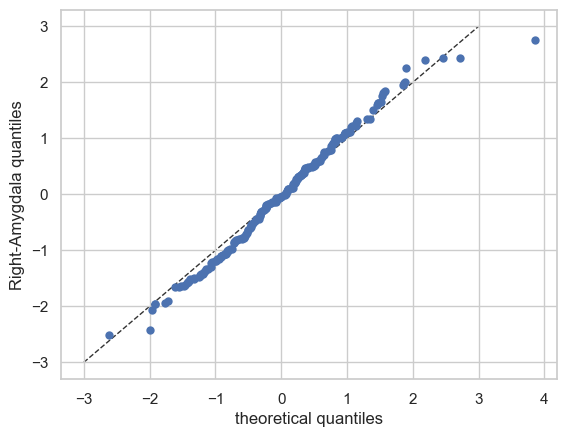

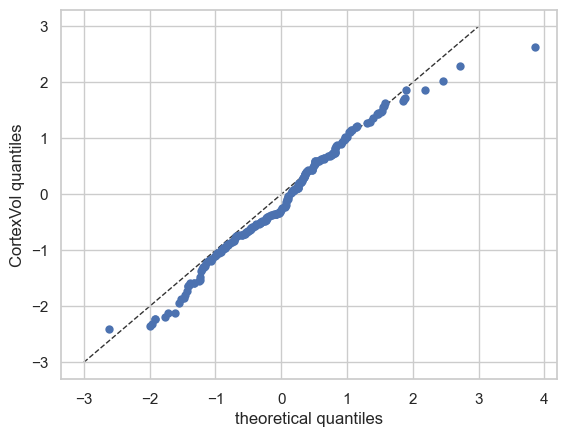

In [8]:
plot_qq(test, plot_id_line=True)

We can also split the QQ plots by batch effects:

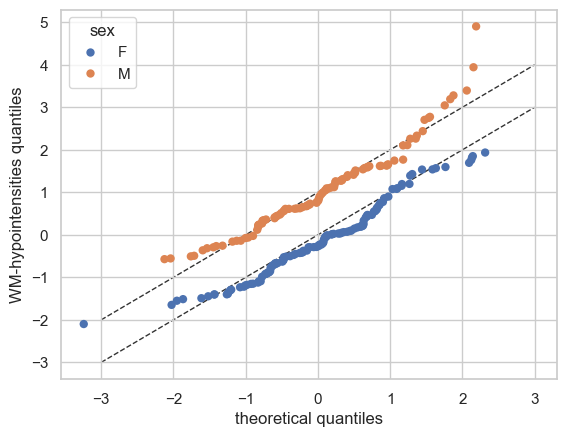

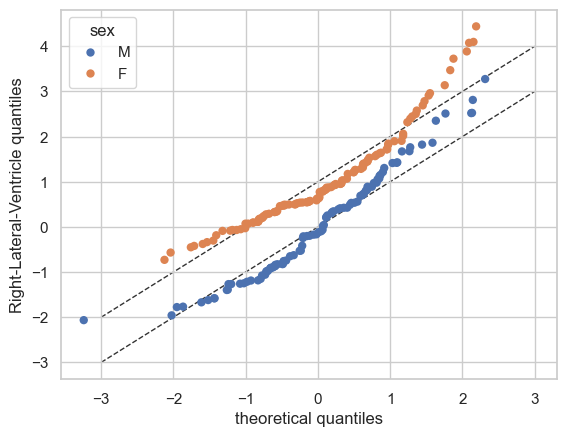

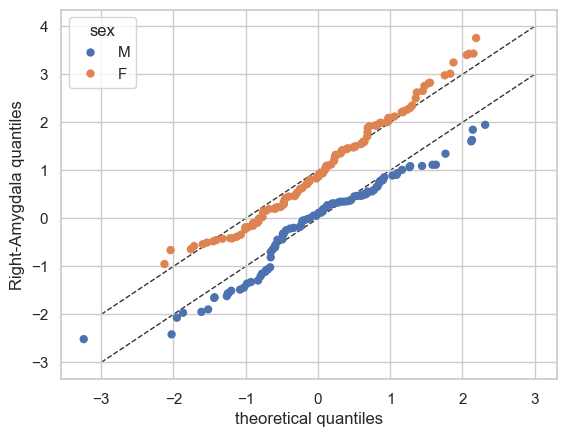

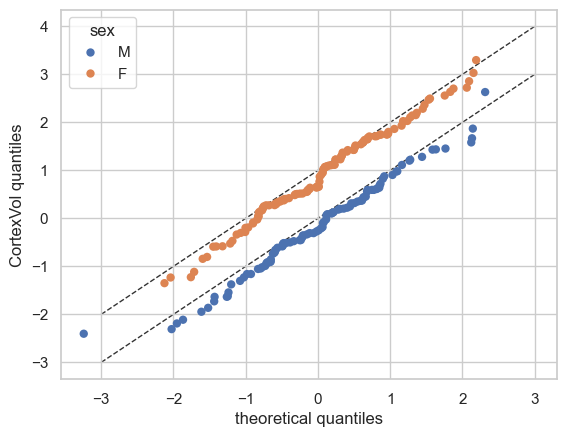

In [9]:
plot_qq(test, plot_id_line=True, hue_data="sex", split_data="sex")
sns.set_theme(style="darkgrid", rc={"axes.facecolor": (0, 0, 0, 0)})

And finally the ridge plot:

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  

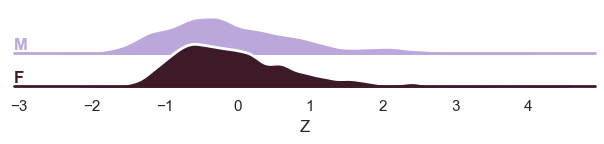

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  

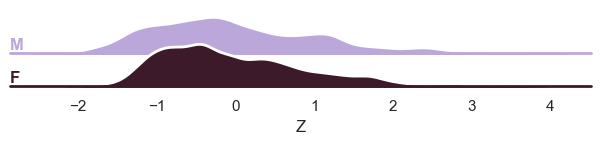

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  

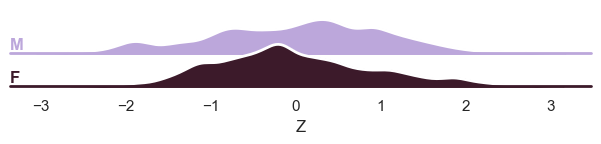

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  

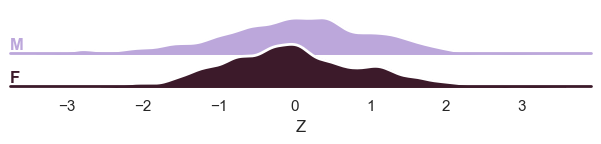

In [10]:
plot_ridge(
    train, "Z", split_by="sex"
)  # We can also show the 'Y' variable, and that will show the marginal distribution of the response variable, per batch effect.

### Model evaluation statistics
Evaluation statistcs are stored in the NormData object:

In [11]:
display(train.get_statistics_df())
display(test.get_statistics_df())

statistic,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,
CortexVol,0.01,2.70,0.47,0.95,0.52,0.69,0.71,0.0,0.48,1.00
Right-Amygdala,0.01,2.51,0.38,1.03,0.39,0.78,0.60,0.0,0.61,1.00
Right-Lateral-Ventricle,0.04,2.55,0.43,0.99,0.23,0.88,0.39,0.0,0.77,0.96
WM-hypointensities,0.04,2.62,0.77,0.65,0.36,0.80,0.52,0.0,0.64,0.94


statistic,MACE,MAPE,MSLL,NLL,R2,RMSE,Rho,Rho_p,SMSE,ShapiroW
response_vars,,,,,,,,,,
CortexVol,0.02,2.27,0.36,0.99,0.41,0.72,0.64,0.0,0.59,0.99
Right-Amygdala,0.02,1.50,0.28,1.10,0.29,0.81,0.51,0.0,0.71,0.99
Right-Lateral-Ventricle,0.04,3.87,0.32,1.12,0.20,0.91,0.28,0.0,0.80,0.95
WM-hypointensities,0.03,1.73,0.46,0.66,0.32,0.61,0.50,0.0,0.68,0.97


## What's next?

Now we have a normative Bayesian linear regression model, we can use it to:

- Make predictions on new data
- Harmonize data, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
- Synthesize new data
- Extend the model using data from new batches

### Predicting

In [12]:
model.predict(test)

Process: 27518 - 2025-06-24 12:16:24 - Making predictions on 4 response variables.
Process: 27518 - 2025-06-24 12:16:24 - Computing z-scores for 4 response variables.
Process: 27518 - 2025-06-24 12:16:24 - Computing z-scores for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:24 - Computing z-scores for CortexVol.
Process: 27518 - 2025-06-24 12:16:24 - Computing z-scores for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:24 - Computing z-scores for Right-Amygdala.
Process: 27518 - 2025-06-24 12:16:24 - Computing centiles for 4 response variables.
Process: 27518 - 2025-06-24 12:16:24 - Computing centiles for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:24 - Computing centiles for CortexVol.
Process: 27518 - 2025-06-24 12:16:24 - Computing centiles for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:24 - Computing centiles for Right-Amygdala.
Process: 27518 - 2025-06-24 12:16:24 - Computing log-probabilities for 4 response variables.
Process: 27518 -

<xarray.NormData> Size: 98kB
Dimensions:            (observations: 216, response_vars: 4, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 10)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U23 368B 'WM-hypointensities' ... 'Co...
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 320B 'MACE' 'MAPE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 2kB 'Munchen_sub96752' ... 'Quee...
    Y                  (observations, response_vars) float64 7kB 2.721e+03 .....
    X                  (observations, covariates) float64 2kB 63.0 ... 23.0
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 7kB 0.7016 ... -...
    centiles           (centile, observations, response_vars) float64 35kB 60...
    logp               (observations, response_vars) float64 7kB -1.104 ... -...
    Yhat               (observations, response_vars) float64 7kB 2.182e+03 .....
    statistics         (response_vars, statistic) float64 320B 0.03426 ... 0....
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {'sex': ['F', 'M'], 'site': ['AnnArbor_a'...
    batch_effect_counts:            {'sex': {'F': 589, 'M': 489}, 'site': {'A...
    batch_effect_covariate_ranges:  {'sex': {'F': {'age': {'min': 7.88, 'max'...
    covariate_ranges:               {'age': {'min': 7.88, 'max': 85.0}}

### Harmonize

Process: 27518 - 2025-06-24 12:16:31 - Harmonizing data on 4 response variables.
Process: 27518 - 2025-06-24 12:16:31 - Harmonizing data for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:31 - Harmonizing data for CortexVol.
Process: 27518 - 2025-06-24 12:16:31 - Harmonizing data for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:31 - Harmonizing data for Right-Amygdala.


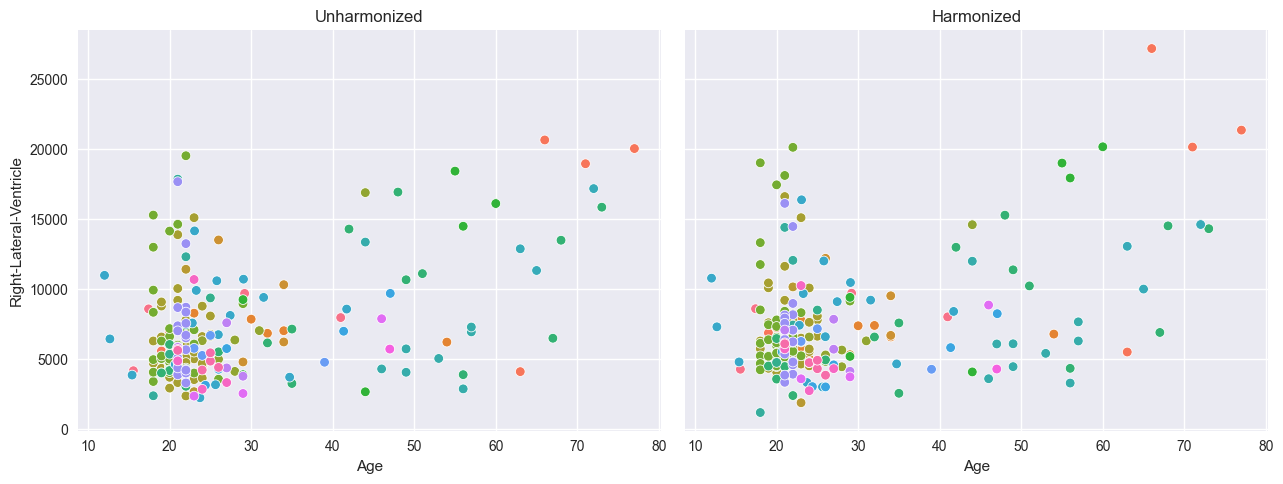

In [13]:
# Harmonizing is also easy:
reference_batch_effect = {
    "site": "Beijing_Zang",
    "sex": "M",
}  # Set a pseudo-batch effect. I.e., this means 'pretend that all data was from this site and sex'

model.harmonize(test, reference_batch_effect=reference_batch_effect)  # <- easy

plt.style.use("seaborn-v0_8")
df = test.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
sns.scatterplot(data=df, x=("X", "age"), y=("Y", feature_to_plot), hue=("batch_effects", "site"), ax=ax[0])
sns.scatterplot(data=df, x=("X", "age"), y=("Y_harmonized", feature_to_plot), hue=("batch_effects", "site"), ax=ax[1])
ax[0].title.set_text("Unharmonized")
ax[1].title.set_text("Harmonized")
ax[0].legend([], [])
ax[1].legend([], [])
ax[0].set_xlabel("Age")
ax[0].set_ylabel(feature_to_plot)
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)
plt.tight_layout()
plt.show()

### Synthesize

Our models can synthesize new data that follows the learned distribution. 

Not only the distribution of the response variables given a covariate is learned, but also the ranges of the covariates _within_ each batch effect. So if we have fitted a model on a number of sites, and subjects from A have an age between 10 and 20, then the synthesized pseudo-subjects from site A will also have an age between 10 and 20.

Not only that, but we also sample the batch effects in the frequency of the batch effects in the original data. So if the train data contained twice as many subjects from site A as site B, then the synthesized pseudo-subjects will also have twice as many subjects from site A as site B.

Process: 27518 - 2025-06-24 12:16:33 - Dataset "synthesized" created.
    - 10000 observations
    - 10000 unique subjects
    - 1 covariates
    - 4 response variables
    - 2 batch effects:
    	sex (2)
	site (23)
    
Process: 27518 - 2025-06-24 12:16:33 - Synthesizing data for 4 response variables.
Process: 27518 - 2025-06-24 12:16:33 - Synthesizing data for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:34 - Synthesizing data for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:34 - Synthesizing data for Right-Amygdala.
Process: 27518 - 2025-06-24 12:16:35 - Synthesizing data for CortexVol.


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 27518 - 2025-06-24 12:16:36 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


Process: 27518 - 2025-06-24 12:16:36 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 4 response variables
    - 2 batch effects:
    	sex (1)
	site (1)
    
Process: 27518 - 2025-06-24 12:16:36 - Computing centiles for 4 response variables.
Process: 27518 - 2025-06-24 12:16:36 - Computing centiles for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:36 - Computing centiles for CortexVol.
Process: 27518 - 2025-06-24 12:16:36 - Computing centiles for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:36 - Computing centiles for Right-Amygdala.
Process: 27518 - 2025-06-24 12:16:38 - Harmonizing data on 4 response variables.
Process: 27518 - 2025-06-24 12:16:38 - Harmonizing data for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:39 - Harmonizing data for CortexVol.
Process: 27518 - 2025-06-24 12:16:40 - Harmonizing data for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:41 - Harmonizing data for Right-A

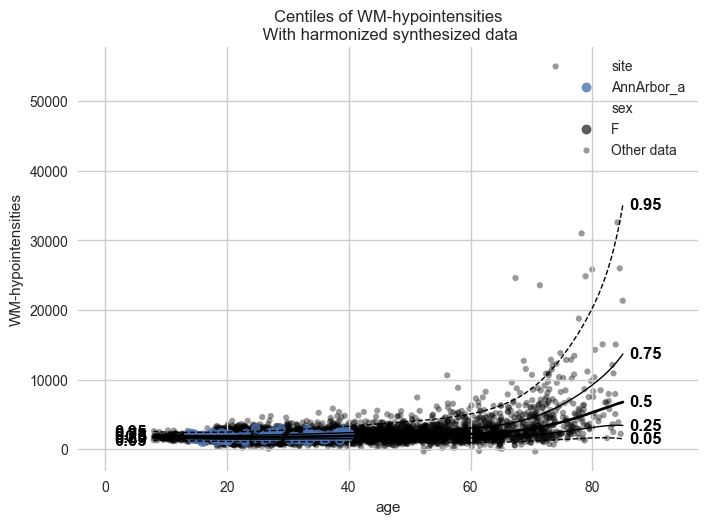

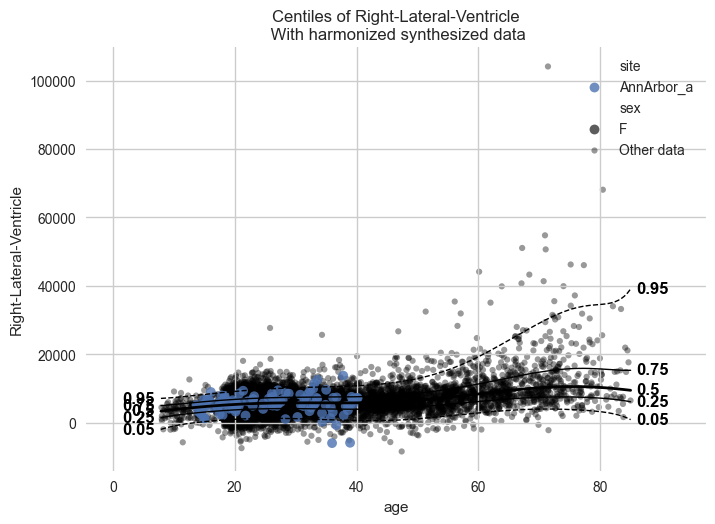

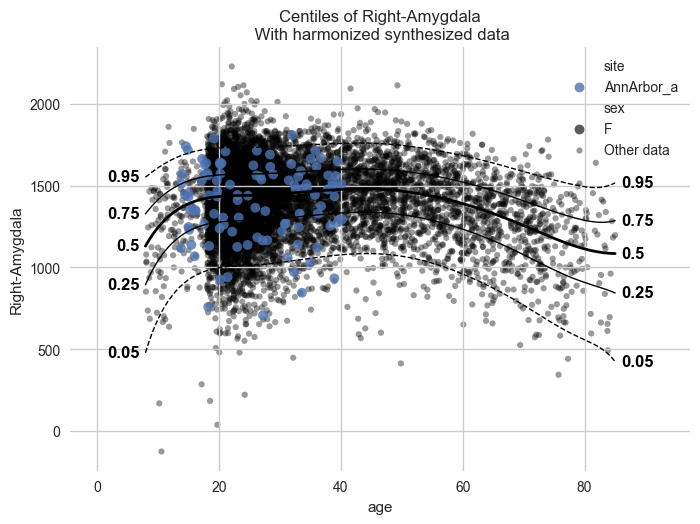

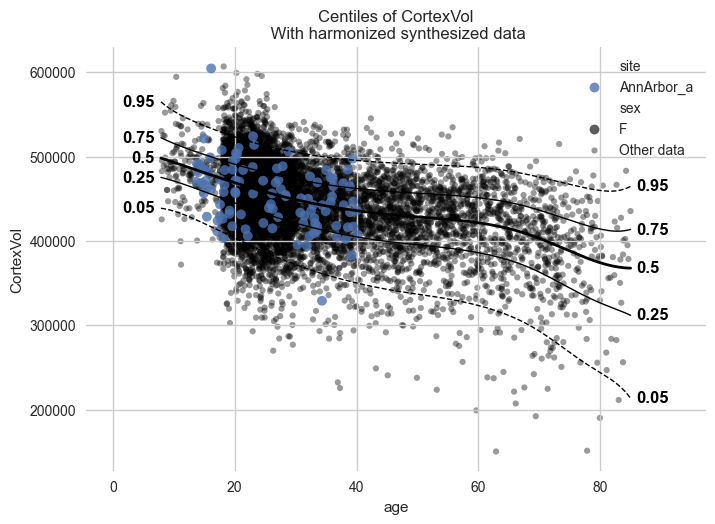

In [14]:
# Generate 10000 synthetic datapoints from scratch
synthetic_data = model.synthesize(covariate_range_per_batch_effect=True, n_samples=10000)  # <- also easy
plot_centiles(
    model,
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=synthetic_data,
    show_other_data=True,
    harmonize_data=True,
    show_legend=True,
)


Process: 27518 - 2025-06-24 12:16:42 - Synthesizing data for 4 response variables.
Process: 27518 - 2025-06-24 12:16:42 - Synthesizing data for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:43 - Synthesizing data for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:43 - Synthesizing data for Right-Amygdala.
Process: 27518 - 2025-06-24 12:16:43 - Synthesizing data for CortexVol.
Process: 27518 - 2025-06-24 12:16:43 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 4 response variables
    - 2 batch effects:
    	sex (1)
	site (1)
    
Process: 27518 - 2025-06-24 12:16:43 - Computing centiles for 4 response variables.
Process: 27518 - 2025-06-24 12:16:43 - Computing centiles for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:43 - Computing centiles for CortexVol.
Process: 27518 - 2025-06-24 12:16:43 - Computing centiles for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:43 - Computing centiles for R

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 27518 - 2025-06-24 12:16:43 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


Process: 27518 - 2025-06-24 12:16:43 - Harmonizing data on 4 response variables.
Process: 27518 - 2025-06-24 12:16:43 - Harmonizing data for Right-Lateral-Ventricle.
Process: 27518 - 2025-06-24 12:16:43 - Harmonizing data for CortexVol.
Process: 27518 - 2025-06-24 12:16:43 - Harmonizing data for WM-hypointensities.
Process: 27518 - 2025-06-24 12:16:43 - Harmonizing data for Right-Amygdala.


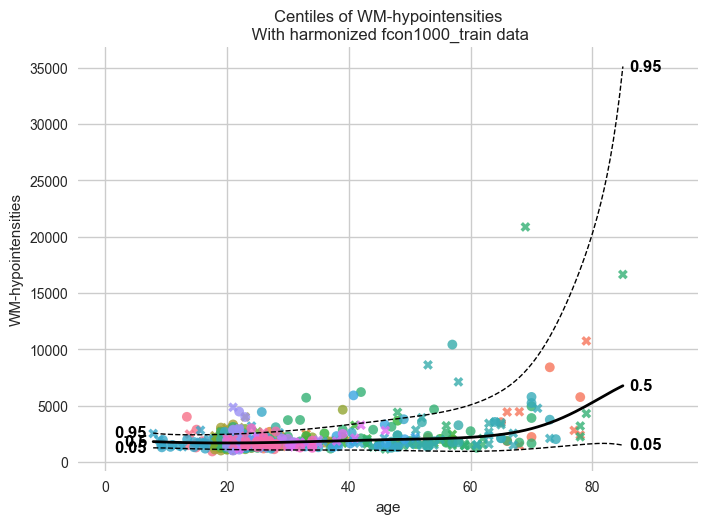

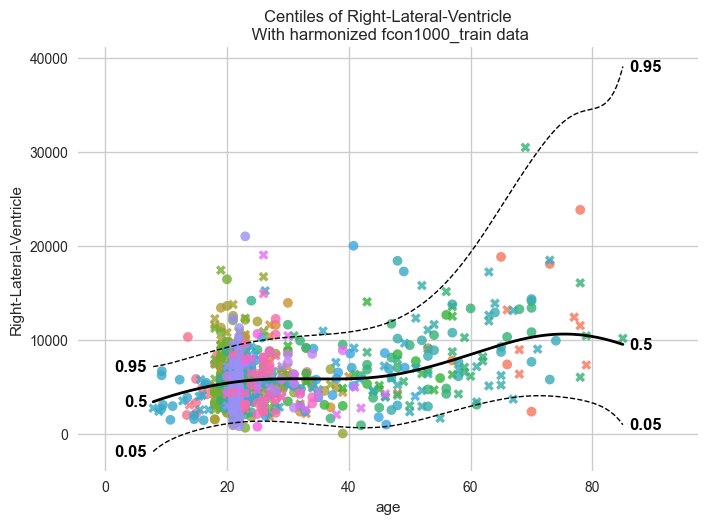

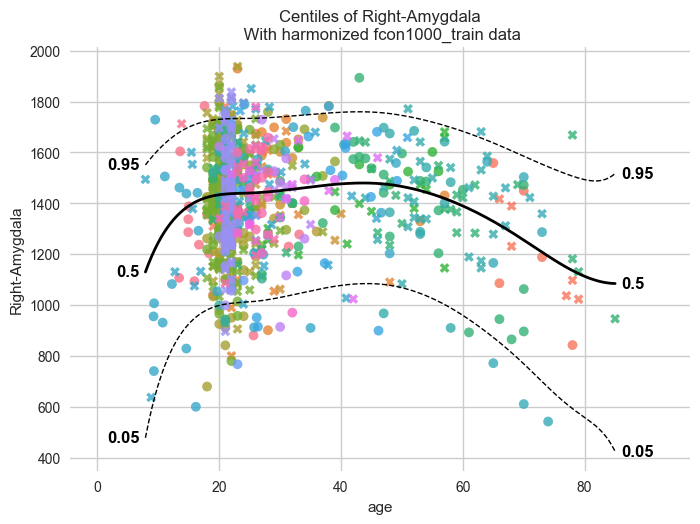

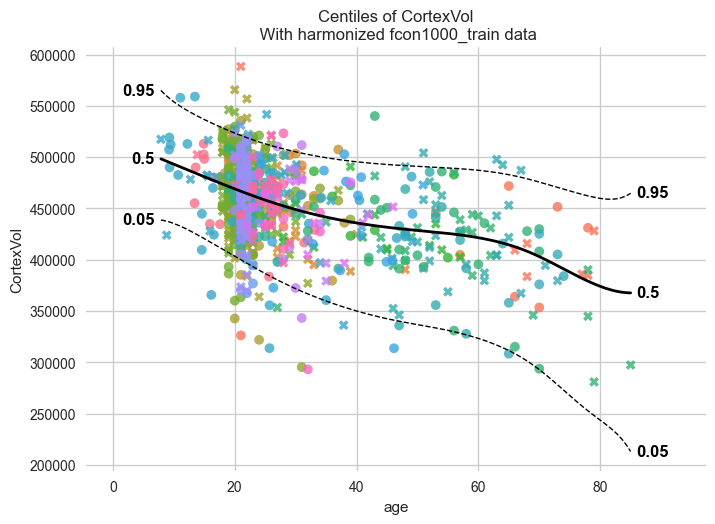

In [15]:
# Synthesize new Y data for existing X data
new_test_data = test.copy()

# Remove the Y data, this way we will synthesize new Y data for the existing X data
if hasattr(new_test_data, "Y"):
    del new_test_data["Y"]

synthetic = model.synthesize(new_test_data)  # <- will fill in the missing Y data
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot arbitrary centiles
    covariate="age",  # Which covariate to plot on the x-axis
    scatter_data=train,  # Scatter the train data points
    batch_effects="all",  # You can set this to "all" to show all batch effects
    show_other_data=True,  # Show data points that do not match any batch effects
    harmonize_data=True,  # Set this to False to see the difference
    show_legend=False,  # Don't show the legend because it crowds the plot
)

## Next steps

Please see the other tutorials for more examples, and we also recommend you to read the documentation! As this toolkit is still in development, the documentation may not be up to date. If you find any issues, please let us know! 

Also, feel free to contact us on Github if you have any questions or suggestions.

Have fun modeling!